In [1]:
import skimage.io as skio
import skimage
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import numpy as np
from tools import *
from sklearn.model_selection import train_test_split
import random
import skimage.filters as skf
import skimage.morphology as skm

Number of CPU cores available : 4


In [2]:
DATASET = ['Fluo-N2DL-HeLa','PhC-C2DH-U373']
idx = 0

IM_PATH = glob.glob(f'data/{DATASET[idx]}/01/*.tif') + glob.glob(f'data/{DATASET[idx]}/02/*.tif')
TG_PATH = glob.glob(f'data/{DATASET[idx]}/01_ST/SEG/*.tif') + glob.glob(f'data/{DATASET[idx]}/02_ST/SEG/*.tif')

In [3]:
img, tg = [], []
for im_path, tg_path in zip(IM_PATH,TG_PATH) :
    im = skio.imread(im_path,plugin='pil')
    im = skimage.img_as_float(im)
    im = (im -im.min())/(im.max() - im.min() + 1e-6)
    img.append(im)
    tg.append(skio.imread(tg_path,plugin='pil') > 0)

In [4]:
#To avoid memory storage error
img = img[:int(len(img)/4)] #Divide by 4 for dataset 0 and 2 for dataset 1
tg = tg[:int(len(tg)/4)]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(img,tg,test_size=0.25,shuffle=True,random_state=42)
len(X_train)

34

In [6]:
BF = Bench_Filters(n_estimators=9)
BF.add_identity()
BF.add_gaussian(0.5)
BF.add_gaussian(1)
BF.add_gaussian(5)
BF.add_median(skm.disk(3))
BF.add_median()
BF.add_sobel()
BF.add_farid()
BF.add_prewitt()
BF.add_roberts()
BF.add_scharr()

In [7]:
BF.fit(X_train, y_train)

Applying filters to dataset: 34it [00:23,  1.45it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 9building tree 2 of 9
building tree 3 of 9

building tree 4 of 9
building tree 5 of 9
building tree 6 of 9
building tree 7 of 9
building tree 8 of 9
building tree 9 of 9


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed: 18.2min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed: 18.2min finished


In [8]:
y_pred = BF.predict(X_test)

Applying filters to dataset: 12it [00:08,  1.36it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    9.8s finished


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 3., 3., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 

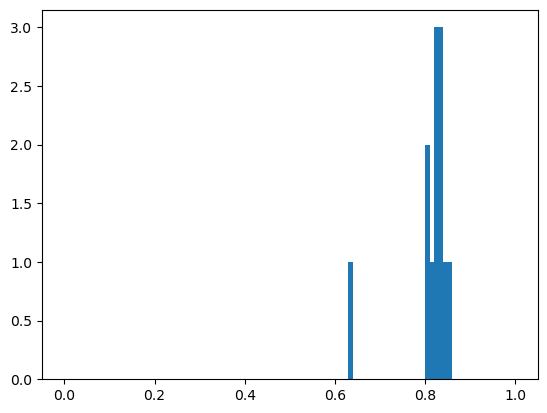

In [9]:
results = []
for i, pred in enumerate(y_pred):
    results.append(jaccard_score(y_test[i],pred,average='micro'))
plt.hist(results,bins=100,range=(0,1))

Applying filters to dataset: 1it [00:00,  1.44it/s]
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.8s finished


Text(0.5, 1.0, 'false positive')

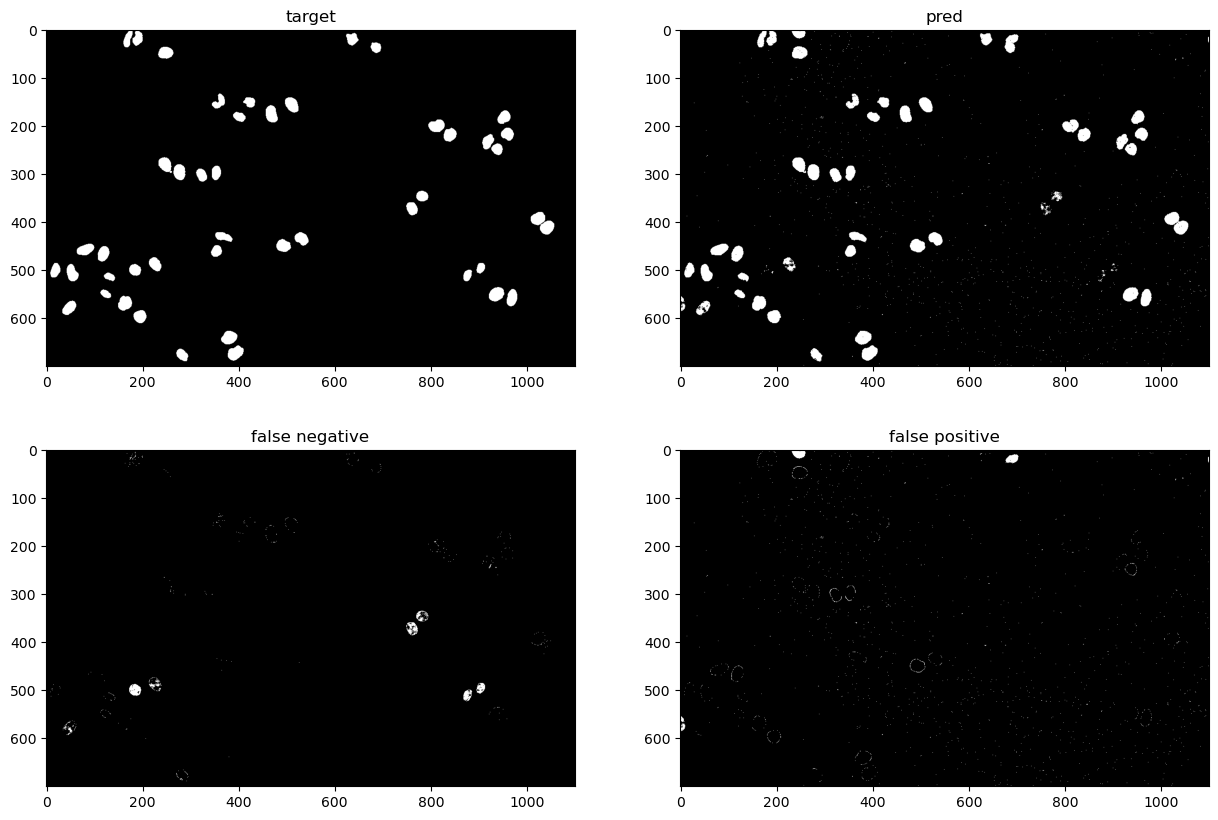

In [10]:
n_im = random.randrange(len(y_test))
target = y_test[n_im]
seg = BF.predict([X_test[n_im]])[0] > 0.6

fig, ax = plt.subplots(2,2,figsize=(15,10))
ax[0,0].imshow(target,cmap='gray')
ax[0,0].set_title('target')
ax[0,1].imshow(seg,cmap='gray')
ax[0,1].set_title('pred') 
ax[1,0].imshow(target & ~seg,cmap='gray')
ax[1,0].set_title('false negative')
ax[1,1].imshow(~target & seg,cmap='gray') 
ax[1,1].set_title('false positive')